In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval[tensorflow]
except Exception:
    pass

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from dataeval.detectors import OOD_AE, OOD_VAEGMM
from dataeval.models.tensorflow import AE, VAEGMM, create_model

tf.random.set_seed(108)
tf.keras.utils.set_random_seed(408)

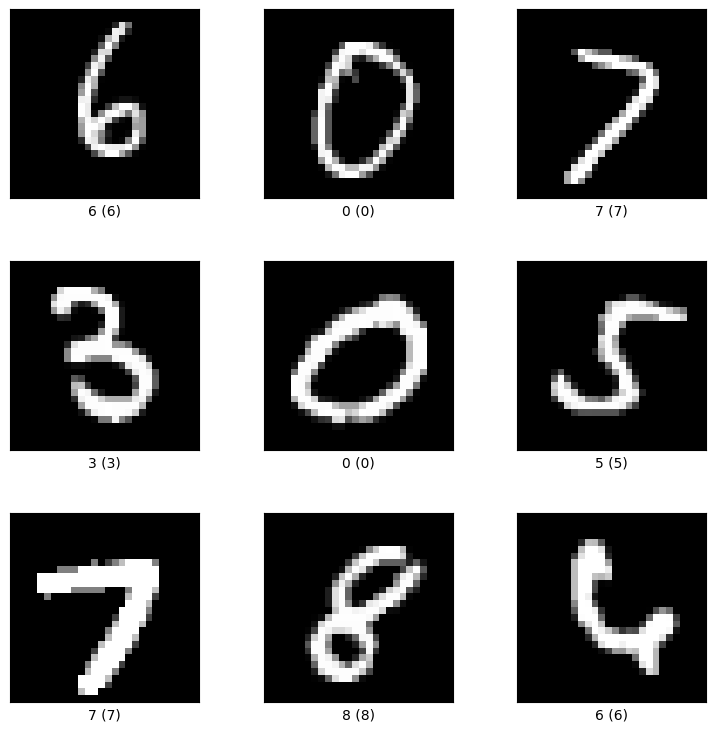

In [3]:
# Load in the mnist dataset from tensorflow datasets
(images, ds_info) = tfds.load(
    "mnist",
    split="train[:2000]",
    with_info=True,
)  # type: ignore

images = images.shuffle(images.cardinality())
tfds.visualization.show_examples(images, ds_info)
images = np.array([i["image"] for i in images], dtype=np.float32) / 255.0
input_shape = images[0].shape

In [4]:
detectors = [
    OOD_AE(create_model(AE, input_shape)),
    OOD_VAEGMM(create_model(VAEGMM, input_shape)),
]

In [5]:
for detector in detectors:
    print(f"Training {detector.__class__.__name__}...")
    detector.fit(images, threshold_perc=99, epochs=20, verbose=False)

Training OOD_AE...


Training OOD_VAEGMM...


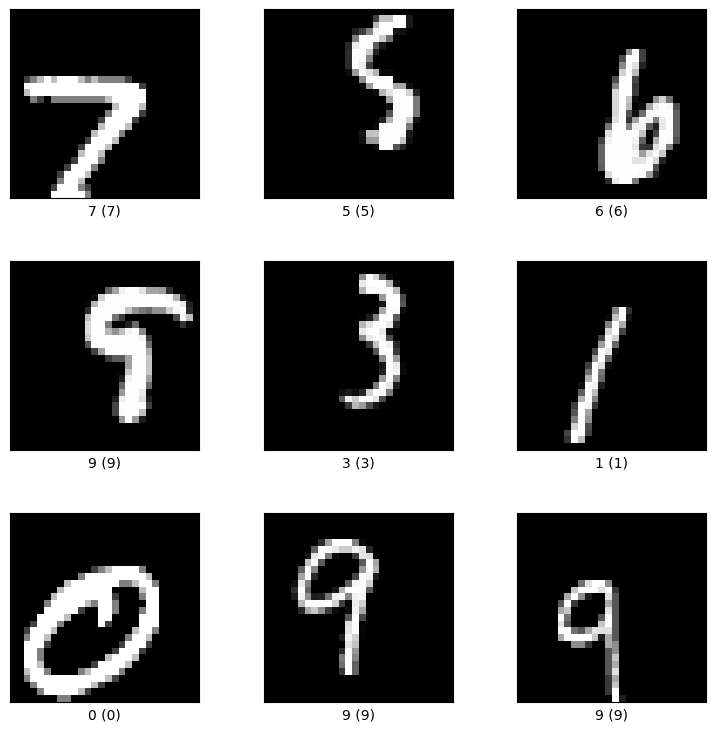

(2000, 28, 28, 1)


In [6]:
corr_images, ds_info = tfds.load(
    "mnist_corrupted/translate",
    split="train[:2000]",
    with_info=True,
)  # type: ignore

corr_images = corr_images.shuffle(corr_images.cardinality())
tfds.visualization.show_examples(corr_images, ds_info)
corr_images = np.array([i["image"] for i in corr_images], dtype=np.float32) / 255.0
# corr_images = corr_images.ravel().reshape((corr_images.shape[0], -1))
print(corr_images.shape)

In [7]:
[(type(detector).__name__, np.mean(detector.predict(images).is_ood)) for detector in detectors]

[('OOD_AE', 0.01), ('OOD_VAEGMM', 0.0115)]

In [8]:
[(type(detector).__name__, np.mean(detector.predict(corr_images).is_ood)) for detector in detectors]

[('OOD_AE', 0.9905), ('OOD_VAEGMM', 0.007)]